# Integrated Gradient Experiments

In [2]:
from pathlib import Path
import numpy as np 
import xarray as xr 

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from neuralhydrology.utils.config import Config

# Load the data [`PixelDataLoader`]

In [3]:
run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_PIXEL_ALL_STATIC_0406_093025")
run_dir = Path("/datadrive/data/runs/azure_nh_runoff_30EPOCH_PIXEL_ALL_STATIC_0406_093025")

# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

In [4]:
ds = xr.open_dataset(Path("/home/tommy/spatio_temporal/data/ALL_dynamic_ds.nc"))
# static_data = 

In [5]:
res_fp = get_test_filepath(run_dir, epoch=30)
preds = get_all_station_ds(res_fp)

100%|██████████| 669/669 [00:00<00:00, 2017.14it/s]


# Load model

In [6]:
# load trained model
model = get_model(cfg).to(cfg.device)
_load_weights(model, cfg)
model

Using the model weights from /datadrive/data/runs/azure_nh_runoff_30EPOCH_PIXEL_ALL_STATIC_0406_093025/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

# integrated gradients?

In [6]:
import pandas as pd
from neuralhydrology.datasetzoo import PixelDataset
from neuralhydrology.datautils.utils import load_basin_file
from neuralhydrology.datasetzoo import CamelsGB
import pickle 
import random
from tqdm import tqdm 


# GET the test period 
test_date_range = pd.date_range(cfg.test_start_date, cfg.test_end_date)
n_time_steps = len(test_date_range)

# GET the list of training basins = basin_file
if cfg.dataset == "pixel":
    basins = [sid for sid in preds.station_id.values]
else:
    basins = load_basin_file(cfg.train_basin_file)
    
#  GET the scaler
with open(cfg.run_dir / "train_data/train_data_scaler.p", "rb") as fp:
    scaler = pickle.load(fp)

# GET the model
device = cfg.device
model = get_model(cfg).to(device)
_load_weights(model, cfg)

Using the model weights from /datadrive/data/runs/azure_nh_runoff_30EPOCH_PIXEL_ALL_STATIC_0406_093025/model_epoch030.pt


CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(25, 64)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

# Initial interpretation of integrated gradients

In [7]:
%load_ext autoreload
%autoreload 2

from scripts.integrated_gradients import create_gradient_xarray

In [8]:
gradients = create_gradient_xarray(cfg, run_dir)
# gradients.to_netcdf(run_dir / "gradients.nc")

Creating Gradient Xarray: 100%|██████████| 503/503 [00:08<00:00, 56.04it/s, 51001] 


In [14]:
gradients

<xarray.Dataset>
Dimensions:        (seq_length: 365, station_id: 499, target_time: 4018)
Coordinates:
  * station_id     (station_id) <U6 '27077' '54027' '68003' ... '17004' '51001'
  * target_time    (target_time) datetime64[ns] 1998-01-01 ... 2008-12-31
  * seq_length     (seq_length) int64 364 363 362 361 360 359 ... 5 4 3 2 1 0
Data variables:
    pet            (station_id, target_time, seq_length) float64 4.823e-05 .....
    precipitation  (station_id, target_time, seq_length) float64 2.428e-05 .....
    temperature    (station_id, target_time, seq_length) float64 -9.388e-06 ....

# visualise gradients

In [10]:
med = gradients.mean(dim="target_time").sel(seq_length=range(0, 20)).isel(station_id=0)
med

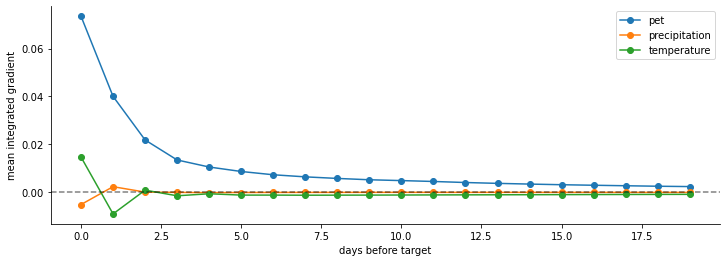

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 4))

for var in gradients.data_vars:
    ax.plot(med.seq_length, med[var], marker="o", label=var)

# var = "precipitation"
# ax.plot(med.seq_length, med[var], marker="o", label=var)

ax.axhline(0, color="k", alpha=0.5, ls="--")
ax.set_ylabel("mean integrated gradient")
ax.set_xlabel("days before target")
plt.legend()
sns.despine()

## spatial interpretation

In [15]:
from scripts.geospatial import (initialise_gb_spatial_plot, load_latlon_points)

In [16]:
points = load_latlon_points(Path("/home/tommy/spatio_temporal/data"))

499


<AxesSubplot:>

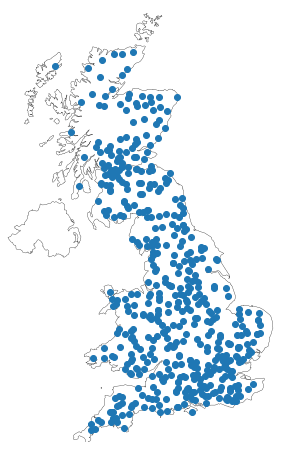

In [17]:
sids = gradients["station_id"].values
ax = initialise_gb_spatial_plot()
print(sum([v in sids for v in points.index.astype(str)]))
points.loc[[v in sids for v in points.index.astype(str)]].plot(ax=ax)

# Interpretation

In [29]:
from torch import nn
from torch import Tensor

In [55]:
relu = nn.ReLU()
f = lambda x: 1 - relu(Tensor(1) - x)

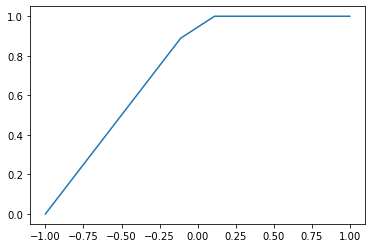

In [56]:
x = np.linspace(-1, 1, 10)
y = f(x)

plt.plot(x, y)